In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

2023-03-07 23:16:50.139312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 23:16:50.763854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/prp/anaconda3/lib/
2023-03-07 23:16:50.763971: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/prp/anaconda3/lib/
2023-03-07 23:16:50.763979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.c

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-03-07 23:16:51.588570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-07 23:16:51.598787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-07 23:16:51.598839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def load_data(path, col=None, verbose=False):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df

In [4]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
        
    
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)

In [5]:
def make_time_features(series):
    
    #convert series to datetimes
    datetimes = pd.DatetimeIndex(series)
    
    days = datetimes.day.values
    months = datetimes.month.values
    years = datetimes.year.values
    
    day = pd.Series(days, name='day')
    month = pd.Series(months, name='months')
    year = pd.Series(years, name='year')
    
    return day, month, year

In [6]:
def split_data(series, train_fraq):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #make train and validation from the remaining
    train_val_data = series
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    test_data = val_data
    
    return train_data, val_data, test_data

In [7]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

In [17]:
def build_dataset(train_fraq=0.80, n_steps=24, n_horizon=1, batch_size=256, shuffle_buffer=500, expand_dims=False, multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    tf.random.set_seed(23)
    data_path = "/mnt/d/Learning/tensorflow_learning/datasets/Stock_data/IBM.csv"
    if multi_var:
        data = load_data(data_path, col=['Close', 'Date', 'High', 'Low', 'Adj Close', "Volume"])
        day, months, years = make_time_features(data.Date)
        data = pd.concat([data.drop(['Date'], axis=1), day, months, years], axis=1)
    else:
        data = load_data(data_path, col=['Close'])
        
    data = clean_data(data)
    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    
    train_data, val_data, test_data = split_data(data, train_fraq=train_fraq)
    
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

In [18]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps=7
    n_horizon=1
    if multivar:
        n_features=8
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr

In [19]:
model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}

def get_callbacks(model_name):
  callbacks = []
  MC = tf.keras.callbacks.ModelCheckpoint(f'saved_models/ts_practice_5/{model_name}', monitor='val_loss', save_best_only='True', verbose=1)
  ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights='True')
  return [MC, ES]

def run_model(model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=False)
    train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=False)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks= get_callbacks(model.name))

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

In [20]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model


dnn = dnn_model(*get_params(multivar=False))
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense (Dense)               (None, 128)               1024      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,665
Trainable params: 17,665
Non-trainable par

In [21]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

cnn = cnn_model(*get_params(multivar=False))
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             8256      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0       

In [22]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params(multivar=False))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 72)             21312     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129    

In [23]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=False))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             8256      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 1, 72)             39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

In [24]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params(multivar=False))
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 7, 1)]       0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 6, 64)        192         ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 3, 64)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2, 64)        8256        ['max_pooling1d[0][0]']          
                                                                                          

In [25]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=150)
run_model("cnn", cnn_model, model_configs, epochs=150)
run_model("lstm", lstm_model, model_configs, epochs=150)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=150)
run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=150)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Prediction lookback (n_steps): 7
Prediction horizon (n_horizon): 1
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150


2023-03-07 23:17:22.109579: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1e4e8ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-07 23:17:22.109621: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-03-07 23:17:22.116317: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-07 23:17:22.194381: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-07 23:17:22.232928: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     18/Unknown - 2s 22ms/step - loss: 41.1237 - mae: 41.6224
Epoch 1: val_loss improved from inf to 24.42675, saving model to saved_models/ts_practice_5/dnn
INFO:tensorflow:Assets written to: saved_models/ts_practice_5/dnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/dnn/assets


18/18 [==============================] - 3s 73ms/step - loss: 41.1237 - mae: 41.6224 - val_loss: 24.4268 - val_mae: 24.9268
Epoch 2/150
15/18 [========================>.....] - ETA: 0s - loss: 22.1762 - mae: 22.6720
Epoch 2: val_loss improved from 24.42675 to 14.86340, saving model to saved_models/ts_practice_5/dnn
INFO:tensorflow:Assets written to: saved_models/ts_practice_5/dnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/dnn/assets


18/18 [==============================] - 1s 66ms/step - loss: 22.5415 - mae: 23.0374 - val_loss: 14.8634 - val_mae: 15.3634
Epoch 3/150
15/18 [========================>.....] - ETA: 0s - loss: 17.7112 - mae: 18.2058
Epoch 3: val_loss did not improve from 14.86340
18/18 [==============================] - 1s 37ms/step - loss: 18.1680 - mae: 18.6626 - val_loss: 17.0777 - val_mae: 17.5777
Epoch 4/150
15/18 [========================>.....] - ETA: 0s - loss: 15.3690 - mae: 15.8624
Epoch 4: val_loss did not improve from 14.86340
18/18 [==============================] - 1s 36ms/step - loss: 15.7540 - mae: 16.2478 - val_loss: 21.3563 - val_mae: 21.8563
Epoch 5/150
15/18 [========================>.....] - ETA: 0s - loss: 13.4486 - mae: 13.9409
Epoch 5: val_loss did not improve from 14.86340
18/18 [==============================] - 1s 37ms/step - loss: 13.7527 - mae: 14.2451 - val_loss: 16.8889 - val_mae: 17.3889
Epoch 6/150
15/18 [========================>.....] - ETA: 0s - loss: 12.9874 - mae: 

Prediction lookback (n_steps): 7
Prediction horizon (n_horizon): 1
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150


2023-03-07 23:17:31.586691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-07 23:17:32.307105: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


     18/Unknown - 3s 33ms/step - loss: 40.9308 - mae: 41.4278
Epoch 1: val_loss improved from inf to 16.20365, saving model to saved_models/ts_practice_5/CNN


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/CNN/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/CNN/assets


18/18 [==============================] - 5s 103ms/step - loss: 40.9308 - mae: 41.4278 - val_loss: 16.2037 - val_mae: 16.7034
Epoch 2/150
15/18 [========================>.....] - ETA: 0s - loss: 20.1968 - mae: 20.6914
Epoch 2: val_loss improved from 16.20365 to 8.11642, saving model to saved_models/ts_practice_5/CNN


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/CNN/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/CNN/assets


18/18 [==============================] - 1s 78ms/step - loss: 20.3967 - mae: 20.8914 - val_loss: 8.1164 - val_mae: 8.6137
Epoch 3/150
15/18 [========================>.....] - ETA: 0s - loss: 17.2068 - mae: 17.7004
Epoch 3: val_loss improved from 8.11642 to 7.16550, saving model to saved_models/ts_practice_5/CNN


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/CNN/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/CNN/assets


18/18 [==============================] - 1s 75ms/step - loss: 17.6902 - mae: 18.1839 - val_loss: 7.1655 - val_mae: 7.6602
Epoch 4/150
15/18 [========================>.....] - ETA: 0s - loss: 15.9570 - mae: 16.4498
Epoch 4: val_loss improved from 7.16550 to 2.83968, saving model to saved_models/ts_practice_5/CNN


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/CNN/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/CNN/assets


18/18 [==============================] - 1s 77ms/step - loss: 16.4190 - mae: 16.9121 - val_loss: 2.8397 - val_mae: 3.3091
Epoch 5/150
15/18 [========================>.....] - ETA: 0s - loss: 15.0750 - mae: 15.5684
Epoch 5: val_loss did not improve from 2.83968
18/18 [==============================] - 1s 37ms/step - loss: 15.4788 - mae: 15.9722 - val_loss: 7.6082 - val_mae: 8.1047
Epoch 6/150
15/18 [========================>.....] - ETA: 0s - loss: 14.7885 - mae: 15.2805
Epoch 6: val_loss did not improve from 2.83968
18/18 [==============================] - 1s 39ms/step - loss: 15.2140 - mae: 15.7062 - val_loss: 3.9447 - val_mae: 4.4302
Epoch 7/150
15/18 [========================>.....] - ETA: 0s - loss: 14.3055 - mae: 14.7965
Epoch 7: val_loss did not improve from 2.83968
18/18 [==============================] - 1s 38ms/step - loss: 14.7821 - mae: 15.2738 - val_loss: 5.3458 - val_mae: 5.8380
Epoch 8/150
15/18 [========================>.....] - ETA: 0s - loss: 14.0716 - mae: 14.5633
Epo

INFO:tensorflow:Assets written to: saved_models/ts_practice_5/CNN/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/CNN/assets


18/18 [==============================] - 2s 86ms/step - loss: 14.4564 - mae: 14.9483 - val_loss: 2.4552 - val_mae: 2.9110
Epoch 9/150
15/18 [========================>.....] - ETA: 0s - loss: 14.0744 - mae: 14.5660
Epoch 9: val_loss did not improve from 2.45523
18/18 [==============================] - 1s 40ms/step - loss: 14.5104 - mae: 15.0025 - val_loss: 2.6970 - val_mae: 3.1510
Epoch 10/150
15/18 [========================>.....] - ETA: 0s - loss: 13.7480 - mae: 14.2407
Epoch 10: val_loss did not improve from 2.45523
18/18 [==============================] - 1s 40ms/step - loss: 14.0553 - mae: 14.5482 - val_loss: 3.0845 - val_mae: 3.5544
Epoch 11/150
15/18 [========================>.....] - ETA: 0s - loss: 13.8186 - mae: 14.3100
Epoch 11: val_loss did not improve from 2.45523
18/18 [==============================] - 1s 37ms/step - loss: 14.1971 - mae: 14.6888 - val_loss: 2.6834 - val_mae: 3.1508
Epoch 12/150
15/18 [========================>.....] - ETA: 0s - loss: 13.6277 - mae: 14.120

Epoch 1/150
     18/Unknown - 3s 55ms/step - loss: 67.6195 - mae: 68.1184
Epoch 1: val_loss improved from inf to 20.57738, saving model to saved_models/ts_practice_5/lstm
INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm/assets


18/18 [==============================] - 6s 216ms/step - loss: 67.6195 - mae: 68.1184 - val_loss: 20.5774 - val_mae: 21.0773
Epoch 2/150
17/18 [===========================>..] - ETA: 0s - loss: 28.9524 - mae: 29.4488
Epoch 2: val_loss improved from 20.57738 to 9.85931, saving model to saved_models/ts_practice_5/lstm
INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm/assets


18/18 [==============================] - 3s 188ms/step - loss: 28.9232 - mae: 29.4197 - val_loss: 9.8593 - val_mae: 10.3569
Epoch 3/150
17/18 [===========================>..] - ETA: 0s - loss: 22.2384 - mae: 22.7338
Epoch 3: val_loss did not improve from 9.85931
18/18 [==============================] - 1s 71ms/step - loss: 22.2382 - mae: 22.7336 - val_loss: 17.5042 - val_mae: 18.0042
Epoch 4/150
17/18 [===========================>..] - ETA: 0s - loss: 19.3983 - mae: 19.8927
Epoch 4: val_loss improved from 9.85931 to 5.90198, saving model to saved_models/ts_practice_5/lstm
INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm/assets


18/18 [==============================] - 4s 199ms/step - loss: 19.4334 - mae: 19.9279 - val_loss: 5.9020 - val_mae: 6.3989
Epoch 5/150
17/18 [===========================>..] - ETA: 0s - loss: 17.5005 - mae: 17.9940
Epoch 5: val_loss did not improve from 5.90198
18/18 [==============================] - 1s 63ms/step - loss: 17.5371 - mae: 18.0306 - val_loss: 23.3668 - val_mae: 23.8665
Epoch 6/150
18/18 [==============================] - ETA: 0s - loss: 15.6011 - mae: 16.0940
Epoch 6: val_loss did not improve from 5.90198
18/18 [==============================] - 1s 66ms/step - loss: 15.6011 - mae: 16.0940 - val_loss: 25.8311 - val_mae: 26.3311
Epoch 7/150
17/18 [===========================>..] - ETA: 0s - loss: 15.2514 - mae: 15.7450
Epoch 7: val_loss did not improve from 5.90198
18/18 [==============================] - 1s 62ms/step - loss: 15.2877 - mae: 15.7813 - val_loss: 29.6427 - val_mae: 30.1427
Epoch 8/150
17/18 [===========================>..] - ETA: 0s - loss: 14.1554 - mae: 14.6

Epoch 1/150
     17/Unknown - 3s 27ms/step - loss: 110.3942 - mae: 110.8942
Epoch 1: val_loss improved from inf to 72.81610, saving model to saved_models/ts_practice_5/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


18/18 [==============================] - 6s 189ms/step - loss: 110.2042 - mae: 110.7042 - val_loss: 72.8161 - val_mae: 73.3161
Epoch 2/150
18/18 [==============================] - ETA: 0s - loss: 34.6274 - mae: 35.1246
Epoch 2: val_loss improved from 72.81610 to 25.05491, saving model to saved_models/ts_practice_5/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


18/18 [==============================] - 3s 193ms/step - loss: 34.6274 - mae: 35.1246 - val_loss: 25.0549 - val_mae: 25.5549
Epoch 3/150
18/18 [==============================] - ETA: 0s - loss: 24.2973 - mae: 24.7926
Epoch 3: val_loss improved from 25.05491 to 9.07503, saving model to saved_models/ts_practice_5/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


18/18 [==============================] - 3s 191ms/step - loss: 24.2973 - mae: 24.7926 - val_loss: 9.0750 - val_mae: 9.5727
Epoch 4/150
18/18 [==============================] - ETA: 0s - loss: 20.4322 - mae: 20.9270
Epoch 4: val_loss improved from 9.07503 to 2.75541, saving model to saved_models/ts_practice_5/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


18/18 [==============================] - 3s 181ms/step - loss: 20.4322 - mae: 20.9270 - val_loss: 2.7554 - val_mae: 3.2230
Epoch 5/150
18/18 [==============================] - ETA: 0s - loss: 18.2028 - mae: 18.6980
Epoch 5: val_loss improved from 2.75541 to 2.54060, saving model to saved_models/ts_practice_5/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


18/18 [==============================] - 4s 200ms/step - loss: 18.2028 - mae: 18.6980 - val_loss: 2.5406 - val_mae: 2.9986
Epoch 6/150
17/18 [===========================>..] - ETA: 0s - loss: 17.5915 - mae: 18.0851
Epoch 6: val_loss improved from 2.54060 to 2.45723, saving model to saved_models/ts_practice_5/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


18/18 [==============================] - 3s 181ms/step - loss: 17.5902 - mae: 18.0838 - val_loss: 2.4572 - val_mae: 2.9192
Epoch 7/150
18/18 [==============================] - ETA: 0s - loss: 17.3502 - mae: 17.8439
Epoch 7: val_loss did not improve from 2.45723
18/18 [==============================] - 1s 42ms/step - loss: 17.3502 - mae: 17.8439 - val_loss: 3.0823 - val_mae: 3.5582
Epoch 8/150
18/18 [==============================] - ETA: 0s - loss: 17.4901 - mae: 17.9841
Epoch 8: val_loss did not improve from 2.45723
18/18 [==============================] - 1s 41ms/step - loss: 17.4901 - mae: 17.9841 - val_loss: 3.1628 - val_mae: 3.6391
Epoch 9/150
18/18 [==============================] - ETA: 0s - loss: 16.9736 - mae: 17.4673
Epoch 9: val_loss did not improve from 2.45723
18/18 [==============================] - 1s 42ms/step - loss: 16.9736 - mae: 17.4673 - val_loss: 2.9130 - val_mae: 3.3853
Epoch 10/150
16/18 [=========================>....] - ETA: 0s - loss: 16.6213 - mae: 17.1145
E

INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_cnn/assets


18/18 [==============================] - 3s 194ms/step - loss: 16.8869 - mae: 17.3798 - val_loss: 2.4498 - val_mae: 2.9105
Epoch 12/150
15/18 [========================>.....] - ETA: 0s - loss: 16.5536 - mae: 17.0466
Epoch 12: val_loss did not improve from 2.44982
18/18 [==============================] - 1s 41ms/step - loss: 17.0549 - mae: 17.5483 - val_loss: 4.1350 - val_mae: 4.6219
Epoch 13/150
15/18 [========================>.....] - ETA: 0s - loss: 16.2904 - mae: 16.7850
Epoch 13: val_loss did not improve from 2.44982
18/18 [==============================] - 1s 41ms/step - loss: 16.9058 - mae: 17.4006 - val_loss: 3.6567 - val_mae: 4.1404
Epoch 14/150
15/18 [========================>.....] - ETA: 0s - loss: 15.8919 - mae: 16.3848
Epoch 14: val_loss did not improve from 2.44982
18/18 [==============================] - 1s 40ms/step - loss: 16.4067 - mae: 16.9001 - val_loss: 3.3532 - val_mae: 3.8309
Epoch 15/150
15/18 [========================>.....] - ETA: 0s - loss: 15.9060 - mae: 16.

Epoch 1/150
     15/Unknown - 3s 29ms/step - loss: 68.2404 - mae: 68.7389
Epoch 1: val_loss improved from inf to 17.76560, saving model to saved_models/ts_practice_5/lstm_skip


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_skip/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_5/lstm_skip/assets


18/18 [==============================] - 6s 189ms/step - loss: 64.9928 - mae: 65.4912 - val_loss: 17.7656 - val_mae: 18.2656
Epoch 2/150
18/18 [==============================] - ETA: 0s - loss: 33.1872 - mae: 33.6839
Epoch 2: val_loss did not improve from 17.76560
18/18 [==============================] - 1s 40ms/step - loss: 33.1872 - mae: 33.6839 - val_loss: 26.2423 - val_mae: 26.7423
Epoch 3/150
15/18 [========================>.....] - ETA: 0s - loss: 25.9138 - mae: 26.4100
Epoch 3: val_loss did not improve from 17.76560
18/18 [==============================] - 1s 39ms/step - loss: 26.5847 - mae: 27.0812 - val_loss: 23.4035 - val_mae: 23.9035
Epoch 4/150
15/18 [========================>.....] - ETA: 0s - loss: 22.2807 - mae: 22.7763
Epoch 4: val_loss did not improve from 17.76560
18/18 [==============================] - 1s 40ms/step - loss: 22.7798 - mae: 23.2750 - val_loss: 30.8482 - val_mae: 31.3482
Epoch 5/150
15/18 [========================>.....] - ETA: 0s - loss: 19.6985 - mae:

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

Loss Curves


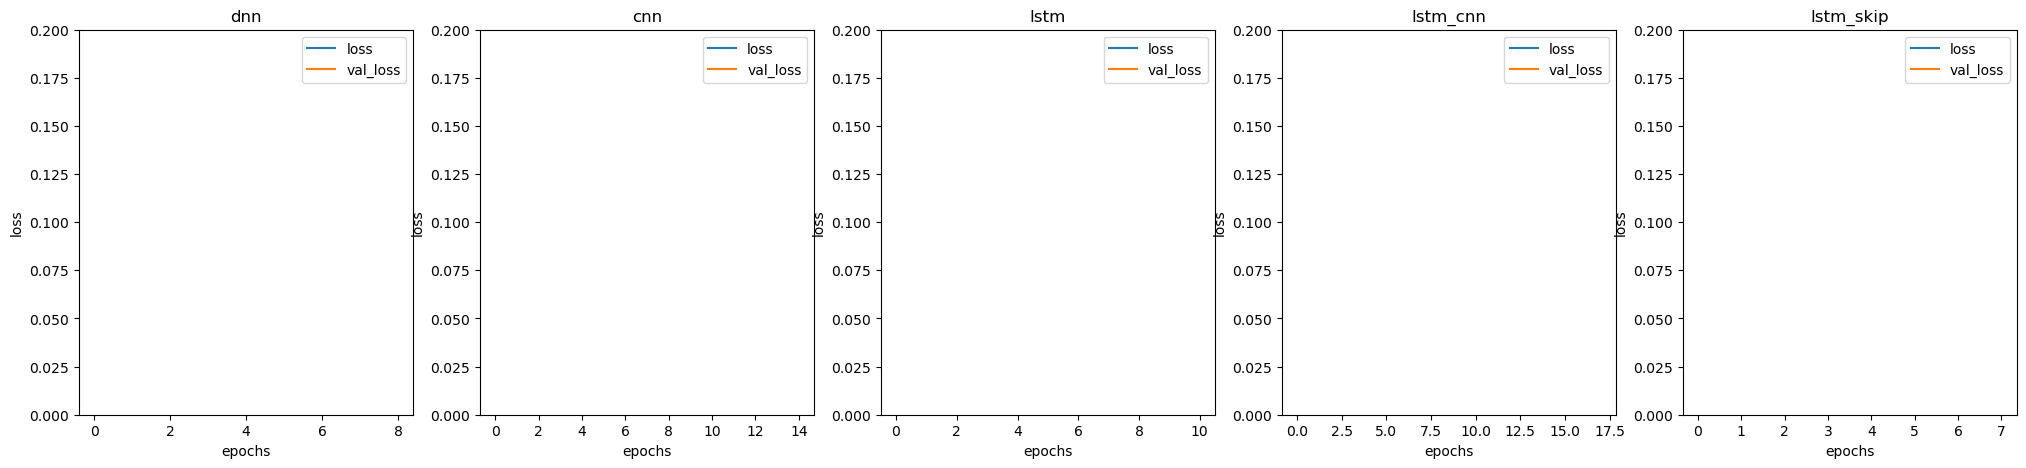

In [26]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


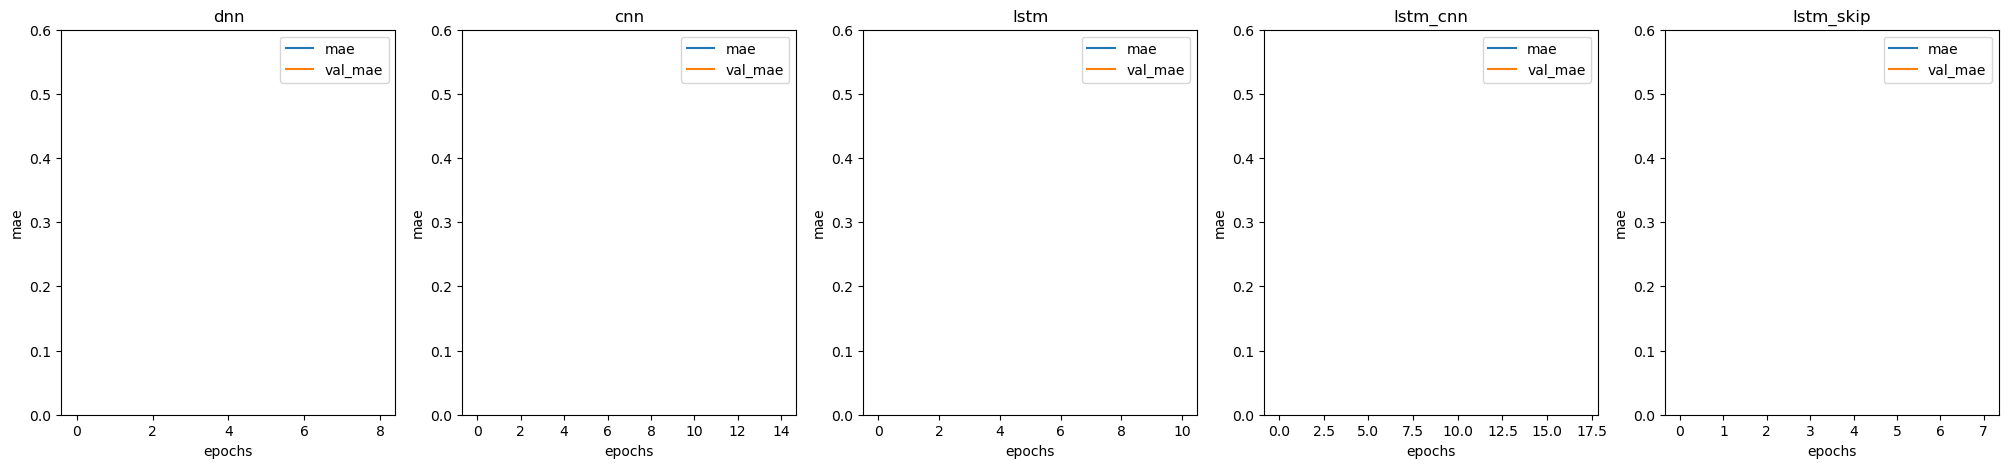

In [27]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)

In [30]:
data_path = "/mnt/d/Learning/tensorflow_learning/datasets/Stock_data/IBM.csv"
data = load_data(data_path, col=['Close'])

In [ ]:
names = list()
performance = list()

for key, value in model_configs.items():
    names.append(key)
    mae = value['model'].evaluate(value['test_ds'])
    performance.append(mae[1])
    
performance_df = pd.DataFrame(performance, index=names, columns=['mae'])
performance_df['error_mw'] = performance_df['mae'] * df['Close'].mean()
print(performance_df)

5/5 [==============================] - 0s 18ms/step
First Two Weeks of Predictions


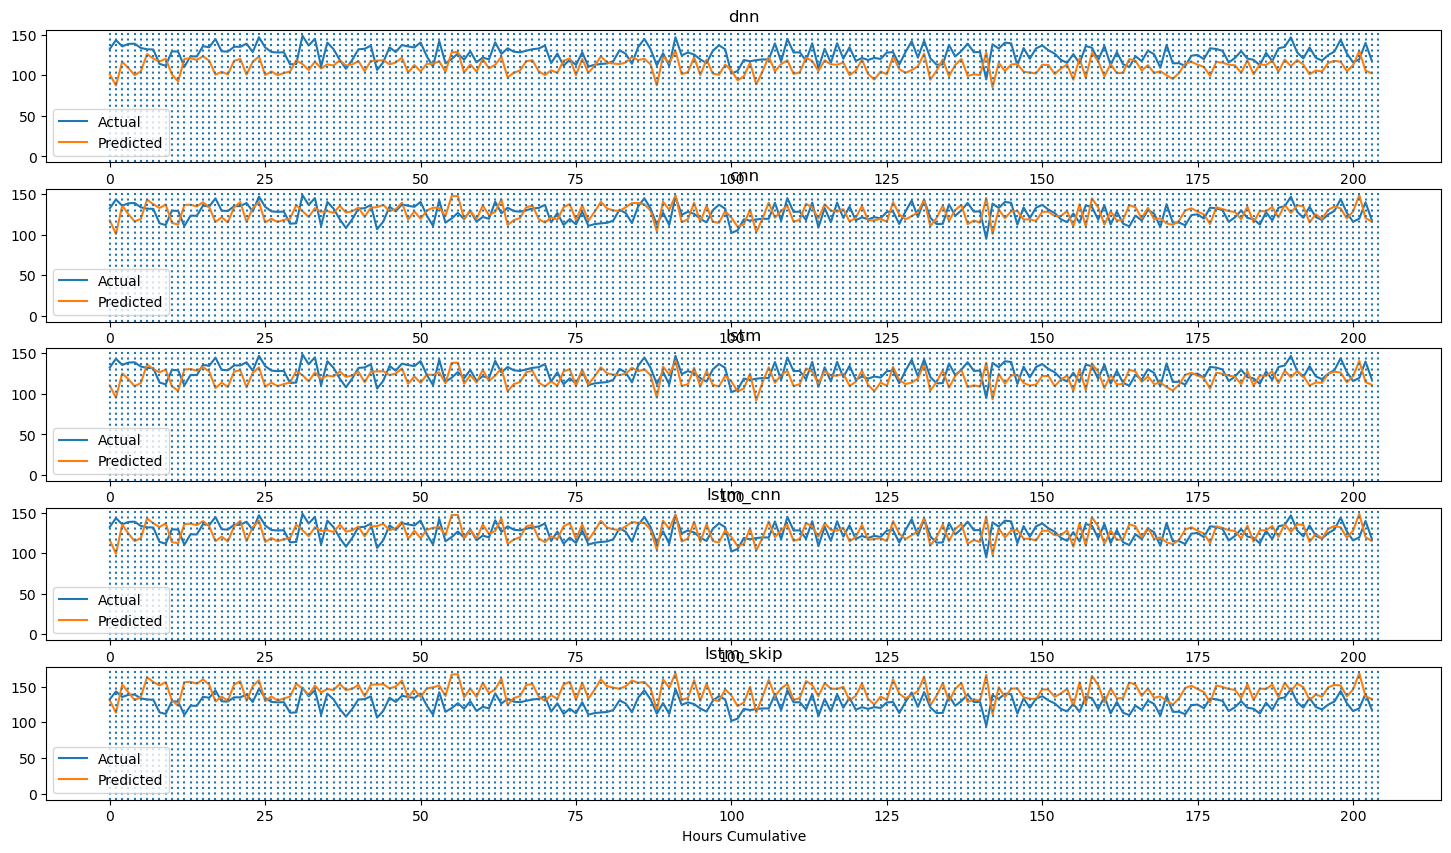

In [28]:
fig, axs = plt.subplots(5, 1, figsize=(18, 10))
days = 204

vline = np.linspace(0, days, days+1)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val['test_ds']
    preds = val['model'].predict(test)

    xbatch, ybatch = iter(test).get_next()

    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

plt.xlabel("Hours Cumulative")
print('First Two Weeks of Predictions')